In [1]:
using StatsBase
using Plots
using JLD2
using Graphs
using SimpleWeightedGraphs
using BlossomV
using GraphsMatching

In [2]:
# struct MatchingResult{U<:Real}
#     weight::U
#     mate::Vector{Int}
# end

# function minimum_weight_perfect_matching end

# function minimum_weight_perfect_matching(
#     g::Graph, w::Dict{E,U}, cutoff, kws...
# ) where {U<:Real,E<:Edge}
#     wnew = Dict{E,U}()
#     for (e, c) in w
#         if c <= cutoff
#             wnew[e] = c
#         end
#     end
#     return minimum_weight_perfect_matching(g, wnew; kws...)
# end

# function minimum_weight_perfect_matching(
#     g::Graph, w::Dict{E,U}; tmaxscale=10.0
# ) where {U<:AbstractFloat,E<:Edge}
#     wnew = Dict{E,Int32}()
#     cmax = maximum(values(w))
#     cmin = minimum(values(w))

#     tmax = typemax(Int32) / tmaxscale # /10 is kinda arbitrary,
#     # hopefully high enough to not occur in overflow problems
#     for (e, c) in w
#         wnew[e] = round(Int32, (c - cmin) / max(cmax - cmin, 1) * tmax)
#     end
#     match = minimum_weight_perfect_matching(g, wnew)
#     weight = zero(U)
#     for i in 1:nv(g)
#         j = match.mate[i]
#         if j > i
#             weight += w[E(i, j)]
#         end
#     end
#     return MatchingResult(weight, match.mate)
# end

# function minimum_weight_perfect_matching(g::Graph, w::Dict{E,U}) where {U<:Integer,E<:Edge}
#     m = BlossomV.Matching(nv(g))
#     for (e, c) in w
#         BlossomV.add_edge(m, src(e) - 1, dst(e) - 1, c)
#     end
#     BlossomV.solve(m)

#     mate = fill(-1, nv(g))
#     totweight = zero(U)
#     for i in 1:nv(g)
#         j = BlossomV.get_match(m, i - 1) + 1
#         mate[i] = j <= 0 ? -1 : j
#         if i < j
#             totweight += w[Edge(i, j)]
#         end
#     end
#     return MatchingResult(totweight, mate)
# end

In [3]:
function initialstate(L::Int)
    ρ = zeros(Bool,L,L)
    return ρ
end

function noiselayer(ρ::AbstractMatrix, p::Float64)
    L = size(ρ)[1]
    noise = rand(L,L) .< p
    return ρ .⊻ noise
end

function magnetization(ρ::AbstractMatrix)
    return mean(ρ)
end

# WARNING: now "horizontal" and "vertical" are on the dual lattice; also now open boundary conditions
function measure(ρ::AbstractMatrix, q::Float64)
    horizontal_checks = noiselayer(ρ .⊻ circshift(ρ,(-1,0)),q)
    vertical_checks = noiselayer(ρ .⊻ circshift(ρ,(0,-1)),q)
    return horizontal_checks, vertical_checks
end

measure (generic function with 1 method)

In [4]:
function detect_charges(horizontal_checks::AbstractMatrix, vertical_checks::AbstractMatrix)
    L = size(vertical_checks)[1]
    sites = vertical_checks .⊻ horizontal_checks .⊻ circshift(vertical_checks,(-1,0)) .⊻ circshift(horizontal_checks,(0,-1))
    return [(j,i) for i in 1:L, j in 1:L][Bool.(sites)]
end

detect_charges (generic function with 1 method)

In [235]:
prob_weight(x::Float64) = -log(x/(1-x))
weight(peff::Float64, q::Float64, m::Bool) = (-1)^m * prob_weight(peff) + prob_weight(q)

site(L,x,y) = L*(mod1(y,L)-1)+mod1(x,L)
unsite(L,s) = (mod1(s,L), div(s-1,L)+1)

function build_matching_graph(checks::Tuple, peff::Float64, q::Float64)
    horizontal_checks, vertical_checks = checks
    L = size(horizontal_checks)[1]
    
    sources = [site(L,x,y) for y in 1:L for x in 1:L]
    horizontal_destinations = [site(L,x+1,y) for y in 1:L for x in 1:L]
    vertical_destinations = [site(L,x,y+1) for y in 1:L for x in 1:L]
    
    horizontal_weights = weight.(peff, q, Bool.(horizontal_checks))
    horizontal_weights[end,:] .= 0
    horizontal_weights = reshape(circshift(horizontal_weights,(0,-1))', L^2, 1)[:,1]

    vertical_weights = weight.(peff, q, Bool.(vertical_checks))
    vertical_weights[:,end] .= 0
    vertical_weights = reshape(circshift(vertical_weights,(-1,0))', L^2, 1)[:,1]
    
    return SimpleWeightedGraph([sources; sources], [horizontal_destinations; vertical_destinations], [horizontal_weights; vertical_weights])
end

build_matching_graph (generic function with 1 method)

In [236]:
function match_charges(fw::Graphs.FloydWarshallState, charges::Vector, L::Int; depth=50)
    subgraph = complete_graph(length(charges))
    weights = Dict{Edge,Float64}()
    for i in 1:length(charges)-1
        for j in i+1:length(charges)
            # if fw.dists[charges[i],charges[j]] < Inf
                weights[Edge(i, j)] = fw.dists[site(L,charges[i]...),site(L,charges[j]...)]
            # end
        end
    end

    match = minimum_weight_perfect_matching(subgraph, weights, depth)
    return match
end

match_charges (generic function with 1 method)

In [237]:
function boundary_filter(checks::Tuple)
    horizontal_checks, vertical_checks = deepcopy(checks)
    L = size(horizontal_checks)[1]
    
    horizontal_checks[end,:] .= false
    vertical_checks[:,end] .= false
    
    return horizontal_checks, vertical_checks
end

boundary_filter (generic function with 1 method)

In [386]:
# modmax(L, a, b) = mod1(max(mod(a,L), mod(b,L)), L)
cyclicmax(L, a, b) = mod(a-b-1, L) == 0 ? a : b 

function heal(checks::Tuple, peff::Float64, q::Float64)
    horizontal_checks, vertical_checks = deepcopy(boundary_filter(checks))
    L = size(horizontal_checks)[1]
    charges = detect_charges(horizontal_checks, vertical_checks)

    # println(charges)

    if length(charges) == 0
        return horizontal_checks, vertical_checks
    end
    
    g = build_matching_graph((horizontal_checks, vertical_checks), peff, q)
    fw = floyd_warshall_shortest_paths(g)
    match = match_charges(fw, charges, L)

    mated = Int[]


    for i in 1:length(charges)
        j = match.mate[i]
        if j in mated
            continue
        end

        println(charges[i], charges[j])

        path = enumerate_paths(fw)[site(L,charges[i]...)][site(L,charges[j]...)]

        sites = unsite.(L, path)
        steps = [((x1,y1),(x2,y2)) for ((x1,y1),(x2,y2)) in zip(sites[1:end-1], sites[2:end])]
        println(steps)
        for ((x1, y1), (x2, y2)) in steps
            if x1 == x2
                vertical_checks[cyclicmax(L, y1, y2), x1] ⊻= true
                # println("y1: $y1, y2: $y2, modmax: $(modmax(L, y1, y2))")
            elseif y1 == y2
                horizontal_checks[y1, cyclicmax(L, x1, x2)] ⊻= true
                # println("x1: $x1, x2: $x2, modmax: $(modmax(L, x1, x2))")
            end
        end

        push!(mated, i)
        push!(mated, j)
    end

    return horizontal_checks, vertical_checks
end

heal (generic function with 1 method)

In [239]:
function track_domains(checks::Tuple)
    horizontal_checks, vertical_checks = checks
    horizontal_checks = Bool.(horizontal_checks)
    vertical_checks = Bool.(vertical_checks)
    L = size(horizontal_checks)[1]
    
    domain = zeros(Bool, L, L)
    for y in 1:L
        for x in 1:L
            if x == 1 && y == 1
                continue
            elseif x == 1
                domain[y, x] = domain[y-1, x] ⊻ horizontal_checks[y-1, x]
            else
                domain[y, x] = domain[y, x-1] ⊻ vertical_checks[y, x-1]
            end
        end
    end
    return domain
end


track_domains (generic function with 1 method)

In [240]:
function correct(ρ::AbstractMatrix, peff::Float64, q::Float64)
    checks = measure(ρ, q)
    checks_copy = deepcopy(checks)
    
    horizontal_checks, vertical_checks = heal(checks, peff, q)
    # println(horizontal_checks, vertical_checks)
    domain = track_domains((horizontal_checks, vertical_checks))
    if magnetization(domain) > 0.5
        domain = .!domain
    end
    
    return ρ .⊻ domain, checks_copy[1], checks_copy[2], horizontal_checks, vertical_checks
end

correct (generic function with 1 method)

In [241]:
function circuit(L::Int, T::Int, p::Float64, peff::Float64, q::Float64)
    ρ = initialstate(L)
    Ms = zeros(Float64, T+1)

    for t in 1:T
        ρ = noiselayer(ρ, p)
        ρ, _, _, _, _ = correct(ρ, peff, q)
        Ms[t+1] = magnetization(ρ)
    end

    return Ms
end

function sample(L::Int, T::Int, p::Float64, peff::Float64, q::Float64, samples::Int)
    Ms = zeros(Float64, T+1)
    for i in 1:samples
        Ms += circuit(L, T, p, peff, q)
    end
    return Ms/samples
end

sample (generic function with 1 method)

In [242]:
# data = Dict{Tuple{Int,Int,Float64,Float64,Float64},Vector{Float64}}()

In [334]:
q = 0.2
p = 0.05
# samples = Dict([4 => 1000
#                 8 => 1000
#                 12 => 100])

# samples = Dict([4 => 10
#                 8 => 10
#                 12 => 1])

samples = 1

for L in 4:4:8
    T = L
    for peff in [0.19]
        println("L=$L, T=$T, p=$p, peff=$peff, q=$q")
        data[(L,T,p,peff,q)] = sample(L, T, p, peff, q, samples)
    end
end

L=4, T=4, p=0.05, peff=0.19, q=0.2


InterruptException: InterruptException:

In [345]:
g = SimpleWeightedGraph([1, 2, 3, 4], [2, 3, 4, 1], [1.0, 1.0, 1.0, 10.0])
fw = floyd_warshall_shortest_paths(g)
enumerate_paths(fw)[1][4]

4-element Vector{Int64}:
 1
 2
 3
 4

In [244]:
# jldsave("25_08_18.jld2"; data)

In [404]:
[key for key in keys(data) if key[2]==2key[1] && key[1] == 12]

11-element Vector{Tuple{Int64, Int64, Float64, Float64, Float64}}:
 (12, 24, 0.05, 0.2, 0.1)
 (12, 24, 0.0, 0.2, 0.1)
 (12, 24, 0.1, 0.2, 0.1)
 (12, 24, 0.3, 0.2, 0.1)
 (12, 24, 0.35, 0.2, 0.1)
 (12, 24, 0.15, 0.2, 0.1)
 (12, 24, 0.2, 0.2, 0.1)
 (12, 24, 0.5, 0.2, 0.1)
 (12, 24, 0.45, 0.2, 0.1)
 (12, 24, 0.25, 0.2, 0.1)
 (12, 24, 0.4, 0.2, 0.1)

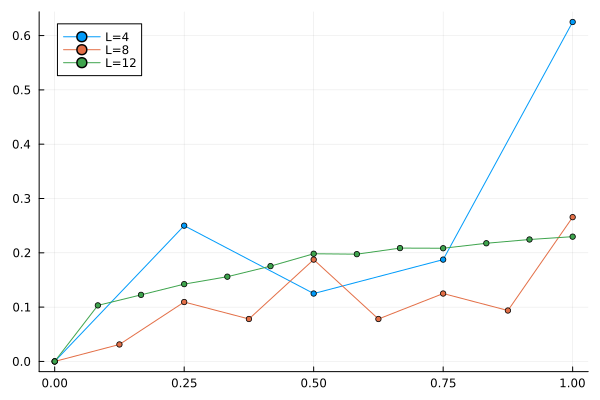

In [398]:
peff = 0.2
q = 0.2
p = 0.05

plt = plot()
for L in 4:4:12
    T = L
    xs = collect(0:T)
    ys = data[(L, T, p, peff, q)]
    plot!(plt, xs/L, ys, label="L=$L", m=3)
end
plt

In [403]:
plt = plot()
for L in 4:4:12
    T = 2L
    q = 0.1
    p = 0.2

    peffs = 0.2:0.05:0.5
    ys = [data[(L,T,p,peff,q)][L] for peff in peffs]

    plot!(plt, peffs, ys, m=3, label="L=$L")
end
plt

KeyError: KeyError: key (4, 8, 0.2, 0.25, 0.1) not found

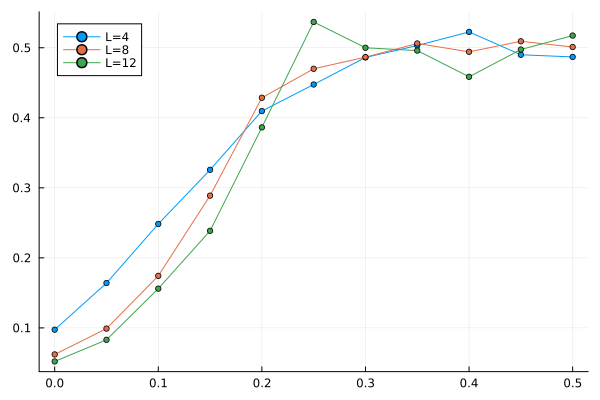

In [406]:
plt = plot()
for L in 4:4:12
    T = 2L
    q = 0.1
    peff = 0.2

    ps = 0.0:0.05:0.5
    ys = [data[(L,T,p,peff,q)][2L] for p in ps]

    plot!(plt, ps, ys, m=3, label="L=$L")
end
plt

In [248]:
data[(8,16,0.0,0.2,0.1)]

17-element Vector{Float64}:
 0.0
 0.062125
 0.061875
 0.059203125
 0.06446875
 0.059671875
 0.062125
 0.068828125
 0.063171875
 0.065109375
 0.064203125
 0.066234375
 0.0668125
 0.061890625
 0.064765625
 0.062078125
 0.065234375

In [387]:
L = 8
peff = 0.5
q = 0.1
ρ = initialstate(L)

horizontal_checks = [0 0 0 0 0 0 0 0
                     0 0 0 0 0 0 0 0
                     0 0 0 0 0 0 0 0
                     0 0 0 0 0 0 0 0
                     0 0 0 1 1 1 0 0
                     0 0 0 0 0 0 0 0
                     0 0 0 0 0 0 0 0
                     0 0 0 0 0 0 0 0]

vertical_checks = [0 0 0 0 0 0 0 0
                   0 0 0 0 0 0 0 0
                   0 0 0 0 0 1 0 0
                   0 0 0 0 0 1 0 0
                   0 0 0 0 0 1 0 0
                   0 0 0 0 0 0 0 0
                   0 0 0 0 0 0 0 0
                   0 0 0 0 0 0 0 0]

charges = detect_charges(horizontal_checks, vertical_checks)
println(charges)
# g = build_matching_graph((horizontal_checks, vertical_checks), peff, q)
# fw = floyd_warshall_shortest_paths(g)
# match = match_charges(fw, charges, L)

# mated = Int[]

# for i in 1:length(charges)
#     j = match.mate[i]
#     if j in mated
#         continue
#     end

#     println(charges[i], charges[j])

#     path = enumerate_paths(fw)[site(L,charges[i]...)][site(L,charges[j]...)]

#     sites = unsite.(L, path)
#     steps = [((x1,y1),(x2,y2)) for ((x1,y1),(x2,y2)) in zip(sites[1:end-1], sites[2:end])]
#     println(steps)
#     for ((x1, y1), (x2, y2)) in steps
#         if x1 == x2
#             vertical_checks[modmax(L, y1, y2), x1] ⊻= true
#         elseif y1 == y2
#             horizontal_checks[y1, modmax(L, x1, x2)] ⊻= true
#         end
#     end

#     push!(mated, i)
#     push!(mated, j)
# end

horizontal_checks, vertical_checks = heal((horizontal_checks, vertical_checks), peff, q)
charges = detect_charges(horizontal_checks, vertical_checks)
println(charges)
domain = track_domains((horizontal_checks, vertical_checks))
if magnetization(domain) > 0.5
    domain = .!domain
end

ρ .⊻ domain

[(3, 5), (6, 2)]
(3, 5)(6, 2)
[((3, 5), (2, 5)), ((2, 5), (1, 5)), ((1, 5), (8, 5)), ((8, 5), (8, 4)), ((8, 4), (8, 3)), ((8, 3), (8, 2)), ((8, 2), (7, 2)), ((7, 2), (6, 2))]
Tuple{Int64, Int64}[]


8×8 BitMatrix:
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  1
 0  0  0  0  0  0  1  1
 0  0  0  0  0  0  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1

In [250]:
modmax(8,1,8)

1

In [251]:
[horizontal_checks vertical_checks]

8×16 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [253]:
fw.dists

64×64 Matrix{Float64}:
 0.0      2.19722  4.39445  4.39445  …  2.19722  2.19722  2.19722  2.19722
 2.19722  0.0      2.19722  4.39445     2.19722  2.19722  2.19722  2.19722
 4.39445  2.19722  0.0      2.19722     2.19722  2.19722  2.19722  2.19722
 4.39445  4.39445  2.19722  0.0         2.19722  2.19722  2.19722  2.19722
 4.39445  4.39445  4.39445  2.19722     2.19722  2.19722  2.19722  2.19722
 4.39445  4.39445  4.39445  4.39445  …  2.19722  2.19722  2.19722  2.19722
 4.39445  4.39445  4.39445  4.39445     2.19722  2.19722  2.19722  2.19722
 2.19722  2.19722  2.19722  2.19722     0.0      0.0      0.0      0.0
 2.19722  4.39445  4.39445  4.39445     2.19722  2.19722  2.19722  2.19722
 4.39445  2.19722  4.39445  6.59167     4.39445  4.39445  4.39445  4.39445
 ⋮                                   ⋱  ⋮                          
 2.19722  2.19722  2.19722  2.19722  …  0.0      0.0      0.0      0.0
 2.19722  2.19722  2.19722  2.19722     0.0      0.0      0.0      0.0
 2.19722  2.19722  2.

In [254]:
L = 8
T = 2L
p = 0.4
peff = 0.1
q = 0.0
samples = 1000
sample(L, T, p, peff, q, samples)

17-element Vector{Float64}:
 0.0
 0.066
 0.103
 0.141
 0.178
 0.214
 0.237
 0.258
 0.291
 0.311
 0.338
 0.357
 0.373
 0.391
 0.405
 0.413
 0.432

In [255]:
L = 8
T = 2L
p = 0.0
peff = 0.01
q = 0.1
samples = 1
sample(L, T, p, peff, q, samples)

InterruptException: InterruptException:

In [256]:
L = 8
peff = 0.5
q = 0.0
ρ = initialstate(L)

horizontal_checks = [0 0 0 0 0 1 0 0
                     0 0 0 0 0 0 0 0
                     0 0 0 0 0 0 0 0
                     0 0 0 1 0 0 0 0
                     0 0 1 0 0 0 0 1
                     0 0 0 0 1 0 1 0
                     0 1 0 1 0 0 0 0
                     0 0 0 0 0 0 0 0]

vertical_checks = [0 0 0 0 0 0 0 1
                   0 0 0 0 0 0 0 1
                   0 0 0 0 0 0 0 0
                   0 0 1 0 0 0 0 0
                   0 1 0 0 0 0 0 0
                   0 0 0 0 0 0 0 0
                   0 0 0 0 0 0 0 0
                   0 0 0 0 0 0 0 0]

charges = detect_charges(horizontal_checks, vertical_checks)
g = build_matching_graph((horizontal_checks, vertical_checks), peff, q)
fw = floyd_warshall_shortest_paths(g)

horizontal_weights = weight.(peff, q, Bool.(horizontal_checks))
horizontal_weights[end,:] .= 0
# horizontal_weights = reshape(circshift(horizontal_weights,(0,-1))', L^2, 1)[:,1]

vertical_weights = weight.(peff, q, Bool.(vertical_checks))
vertical_weights[:,end] .= 0
# vertical_weights = reshape(circshift(vertical_weights,(-1,0))', L^2, 1)[:,1]

# match = match_charges(fw, charges, L)

# horizontal_checks_healed, vertical_checks_healed = heal((horizontal_checks, vertical_checks), peff, q)
# domain = track_domains((horizontal_checks_healed, vertical_checks_healed))
# if magnetization(domain) > 0.5
#     domain = .!domain
# end

# ρ_corrected = ρ .⊻ domain

8-element view(::Matrix{Float64}, :, 8) with eltype Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [257]:
horizontal_weights

8×8 Matrix{Float64}:
 Inf   Inf   Inf   Inf   Inf   Inf   Inf   Inf
 Inf   Inf   Inf   Inf   Inf   Inf   Inf   Inf
 Inf   Inf   Inf   Inf   Inf   Inf   Inf   Inf
 Inf   Inf   Inf   Inf   Inf   Inf   Inf   Inf
 Inf   Inf   Inf   Inf   Inf   Inf   Inf   Inf
 Inf   Inf   Inf   Inf   Inf   Inf   Inf   Inf
 Inf   Inf   Inf   Inf   Inf   Inf   Inf   Inf
  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

In [258]:
enumerate_paths(fw)

64-element Vector{Vector{Vector{Int64}}}:
 [[], [], [], [], [], [], [], [], [], []  …  [], [], [], [], [], [], [], [], [], []]
 [[], [], [], [], [], [], [], [], [], []  …  [], [], [], [], [], [], [], [], [], []]
 [[], [], [], [], [], [], [], [], [], []  …  [], [], [], [], [], [], [], [], [], []]
 [[], [], [], [], [], [], [], [], [], []  …  [], [], [], [], [], [], [], [], [], []]
 [[], [], [], [], [], [], [], [], [], []  …  [], [], [], [], [], [], [], [], [], []]
 [[], [], [], [], [], [], [], [], [], []  …  [], [], [], [], [], [], [], [], [], []]
 [[], [], [], [], [], [], [], [], [], []  …  [], [], [], [], [], [], [], [], [], []]
 [[], [], [], [], [], [], [], [], [], []  …  [], [8, 16, 24, 32, 40, 48, 56], [8, 64, 57], [8, 64, 57, 58], [8, 64, 57, 58, 59], [8, 64, 57, 58, 59, 60], [8, 64, 57, 58, 59, 60, 61], [8, 64, 57, 58, 59, 60, 61, 62], [8, 64, 63], [8, 64]]
 [[], [], [], [], [], [], [], [], [], []  …  [], [], [], [], [], [], [], [], [], []]
 [[], [], [], [], [], [], [], [], [], []

In [259]:
L = 8
peff = 0.5
q = 0.1
ρ = initialstate(L)

horizontal_checks = [0 0 0 0 0 1 0 0
                     0 0 0 0 0 0 0 0
                     0 0 0 0 0 0 0 0
                     0 0 0 1 0 0 0 0
                     0 0 1 0 0 0 0 1
                     0 0 0 0 1 0 1 0
                     0 1 0 1 0 0 0 0
                     0 0 0 0 0 0 0 0]

vertical_checks = [0 0 0 0 0 0 0 1
                   0 0 0 0 0 0 0 1
                   0 0 0 0 0 0 0 0
                   0 0 1 0 0 0 0 0
                   0 1 0 0 0 0 0 0
                   0 0 0 0 0 0 0 0
                   0 0 0 0 0 0 0 0
                   0 0 0 0 0 0 0 0]

detected_charges = detect_charges(horizontal_checks, vertical_checks)

18-element Vector{Tuple{Int64, Int64}}:
 (1, 7)
 (2, 4)
 (2, 7)
 (3, 3)
 (3, 5)
 (3, 7)
 (4, 4)
 (4, 6)
 (4, 7)
 (5, 1)
 (5, 6)
 (6, 1)
 (6, 6)
 (7, 5)
 (7, 6)
 (8, 2)
 (8, 5)
 (8, 8)

In [260]:
horizontal_checks_filtered, vertical_checks_filtered = boundary_filter((horizontal_checks, vertical_checks))
detected_charges = detect_charges(horizontal_checks_filtered, vertical_checks_filtered)

16-element Vector{Tuple{Int64, Int64}}:
 (1, 7)
 (2, 4)
 (2, 7)
 (3, 3)
 (3, 5)
 (3, 7)
 (4, 4)
 (4, 6)
 (4, 7)
 (5, 1)
 (5, 6)
 (6, 1)
 (6, 6)
 (7, 5)
 (7, 6)
 (8, 5)

In [261]:
charges = detect_charges(horizontal_checks_filtered, vertical_checks_filtered)

g = build_matching_graph((horizontal_checks_filtered, vertical_checks_filtered), peff, q)
fw = floyd_warshall_shortest_paths(g)
match = match_charges(fw, charges, L)

mated = Int[]


for i in 1:length(charges)
    j = match.mate[i]
    if j in mated
        continue
    end

    println(charges[i], charges[j])

    path = enumerate_paths(fw)[site(L,charges[i]...)][site(L,charges[j]...)]

    sites = unsite.(L, path)
    steps = [((x1,y1),(x2,y2)) for ((x1,y1),(x2,y2)) in zip(sites[1:end-1], sites[2:end])]
    println(steps)
    # for ((x1, y1), (x2, y2)) in steps
    #     if x1 == x2
    #         vertical_checks[max(y1, y2), x1] ⊻= true
    #     elseif y1 == y2
    #         horizontal_checks[y1, max(x1, x2)] ⊻= true
    #     end
    # end

    push!(mated, i)
    push!(mated, j)
end

(1, 7)(2, 7)
[((1, 7), (2, 7))]
(2, 4)(3, 3)
[((2, 4), (2, 3)), ((2, 3), (3, 3))]
(3, 5)(4, 4)
[((3, 5), (3, 4)), ((3, 4), (4, 4))]
(3, 7)(4, 7)
[((3, 7), (4, 7))]
(4, 6)(5, 6)
[((4, 6), (5, 6))]
(5, 1)(6, 1)
[((5, 1), (6, 1))]
(6, 6)(7, 6)
[((6, 6), (7, 6))]
(7, 5)(8, 5)
[((7, 5), (8, 5))]


In [262]:
    horizontal_weights = weight.(peff, q, Bool.(horizontal_checks_filtered))
    horizontal_weights[4,:] .= 0
    horizontal_weights = reshape(circshift(horizontal_weights,(0,-1))', L^2, 1)[:,1]

    vertical_weights = weight.(peff, q, Bool.(vertical_checks_filtered))
    vertical_weights[:,4] .= 0
    vertical_weights = reshape(circshift(vertical_weights,(-1,0))', L^2, 1)[:,1]

64-element Vector{Float64}:
 2.197224577336219
 2.197224577336219
 2.197224577336219
 0.0
 2.197224577336219
 2.197224577336219
 2.197224577336219
 2.197224577336219
 2.197224577336219
 2.197224577336219
 ⋮
 2.197224577336219
 2.197224577336219
 2.197224577336219
 2.197224577336219
 0.0
 2.197224577336219
 2.197224577336219
 2.197224577336219
 2.197224577336219

In [265]:
vertical_checks .⊻ vertical_checks_filtered

8×8 Matrix{Int64}:
 0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0

In [266]:

horizontal_checks_filtered, vertical_checks_filtered = boundary_filter((horizontal_checks, vertical_checks))

([0 0 … 0 0; 0 0 … 0 0; … ; 0 1 … 0 0; 0 0 … 0 0], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

In [267]:
horizontal_checks

8×8 Matrix{Int64}:
 0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0
 0  0  1  0  0  0  0  1
 0  0  0  0  1  0  1  0
 0  1  0  1  0  0  0  0
 0  0  0  0  0  0  0  0

In [268]:
detected_charges = detect_charges(horizontal_checks_filtered, vertical_checks_filtered)

16-element Vector{Tuple{Int64, Int64}}:
 (1, 7)
 (2, 4)
 (2, 7)
 (3, 3)
 (3, 5)
 (3, 7)
 (4, 4)
 (4, 6)
 (4, 7)
 (5, 1)
 (5, 6)
 (6, 1)
 (6, 6)
 (7, 5)
 (7, 6)
 (8, 5)

In [269]:
sites = vertical_checks .⊻ horizontal_checks .⊻ circshift(vertical_checks,(-1,0)) .⊻ circshift(horizontal_checks,(0,-1))

8×8 Matrix{Int64}:
 0  0  0  0  1  1  0  0
 0  0  0  0  0  0  0  1
 0  0  1  0  0  0  0  0
 0  1  0  1  0  0  0  0
 0  0  1  0  0  0  1  1
 0  0  0  1  1  1  1  0
 1  1  1  1  0  0  0  0
 0  0  0  0  0  0  0  1

In [270]:
circshift(vertical_checks,(-1,0))

8×8 Matrix{Int64}:
 0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0
 0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1

In [271]:
circshift(horizontal_checks,(0,-1))

8×8 Matrix{Int64}:
 0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0
 0  1  0  0  0  0  1  0
 0  0  0  1  0  1  0  0
 1  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0

In [272]:
horizontal_checks

8×8 Matrix{Int64}:
 0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0
 0  0  1  0  0  0  0  1
 0  0  0  0  1  0  1  0
 0  1  0  1  0  0  0  0
 0  0  0  0  0  0  0  0

In [273]:
horizontal_checks

8×8 Matrix{Int64}:
 0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0
 0  0  1  0  0  0  0  1
 0  0  0  0  1  0  1  0
 0  1  0  1  0  0  0  0
 0  0  0  0  0  0  0  0

In [274]:
vertical_checks

8×8 Matrix{Int64}:
 0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0
 0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0

In [275]:
L = 8
ρ = initialstate(L)
ρ, horizontal_checks, vertical_checks, new_horizontal_checks, new_vertical_checks = correct(ρ, 0.5, 0.1)
ρ

8×8 BitMatrix:
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0

In [276]:
heal((horizontal_checks, vertical_checks), 0.1, 0.1)

(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 1 0 … 0 0; 1 0 … 0 0])

In [277]:
test

UndefVarError: UndefVarError: `test` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Pkg in the current active module Main

In [278]:
new_horizontal_checks

8×8 BitMatrix:
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  1
 1  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0

In [279]:
X, Y = boundary_filter((horizontal_checks, vertical_checks))
detect_charges(X,Y)

20-element Vector{Tuple{Int64, Int64}}:
 (1, 1)
 (1, 4)
 (1, 5)
 (1, 7)
 (1, 8)
 (2, 4)
 (2, 5)
 (3, 1)
 (3, 5)
 (3, 6)
 (4, 2)
 (4, 4)
 (4, 6)
 (4, 7)
 (5, 2)
 (5, 4)
 (6, 4)
 (6, 5)
 (7, 6)
 (8, 6)

In [280]:
Y .⊻ vertical_checks

8×8 BitMatrix:
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0

In [281]:
A, B = heal((new_horizontal_checks, new_vertical_checks), 0.5, 0.1)

(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 1 0 … 0 0; 0 1 … 0 0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 1; 1 0 … 0 0])

In [282]:
[A B]

8×16 BitMatrix:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 0  1  1  1  1  1  0  0  1  0  0  0  0  0  0  0

In [283]:
[C D]

8×16 BitMatrix:
 0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  1  0  0  0  1  0

In [285]:
C, D = boundary_filter((A, B))
detect_charges(C, D)

4-element Vector{Tuple{Int64, Int64}}:
 (1, 8)
 (6, 6)
 (8, 6)
 (8, 7)

In [286]:
detect_charges(A,B)

2-element Vector{Tuple{Int64, Int64}}:
 (6, 6)
 (6, 8)

In [287]:
[horizontal_checks vertical_checks]

8×16 BitMatrix:
 0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  1  0  0  0  1  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
 0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0

In [288]:
filtered1, filtered2 = boundary_filter((horizontal_checks, vertical_checks))
[filtered1 filtered2]

8×16 BitMatrix:
 0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  1  1  0  0  0  1  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0

In [289]:
detect_charges(horizontal_checks, vertical_checks)

24-element Vector{Tuple{Int64, Int64}}:
 (1, 1)
 (1, 4)
 (1, 5)
 (1, 7)
 (1, 8)
 (2, 4)
 (2, 5)
 (2, 8)
 (3, 1)
 (3, 5)
 ⋮
 (4, 7)
 (5, 2)
 (5, 4)
 (6, 4)
 (6, 5)
 (7, 6)
 (8, 1)
 (8, 2)
 (8, 6)

In [290]:
detect_charges(filtered1, filtered2)

20-element Vector{Tuple{Int64, Int64}}:
 (1, 1)
 (1, 4)
 (1, 5)
 (1, 7)
 (1, 8)
 (2, 4)
 (2, 5)
 (3, 1)
 (3, 5)
 (3, 6)
 (4, 2)
 (4, 4)
 (4, 6)
 (4, 7)
 (5, 2)
 (5, 4)
 (6, 4)
 (6, 5)
 (7, 6)
 (8, 6)

In [291]:
[new_horizontal_checks new_vertical_checks]

8×16 BitMatrix:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  1
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0

In [292]:
detect_charges(boundary_filter((horizontal_checks, vertical_checks))...)

20-element Vector{Tuple{Int64, Int64}}:
 (1, 1)
 (1, 4)
 (1, 5)
 (1, 7)
 (1, 8)
 (2, 4)
 (2, 5)
 (3, 1)
 (3, 5)
 (3, 6)
 (4, 2)
 (4, 4)
 (4, 6)
 (4, 7)
 (5, 2)
 (5, 4)
 (6, 4)
 (6, 5)
 (7, 6)
 (8, 6)

In [294]:
B

8×8 BitMatrix:
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1
 1  0  0  0  0  0  0  0

In [295]:
A, B = heal((horizontal_checks, vertical_checks), 0.5,0.1)
detect_charges(A,B)

2-element Vector{Tuple{Int64, Int64}}:
 (6, 6)
 (8, 6)

In [296]:
detect_charges(A,B)

2-element Vector{Tuple{Int64, Int64}}:
 (6, 6)
 (8, 6)

In [297]:
A, B = heal((A,B), 0.5,0.1)
detect_charges(A,B)

2-element Vector{Tuple{Int64, Int64}}:
 (6, 6)
 (6, 8)

In [298]:
detect_charges(horizontal_checks, vertical_checks)
detect_charges(new_horizontal_checks, new_vertical_checks)

2-element Vector{Tuple{Int64, Int64}}:
 (6, 6)
 (8, 6)

In [299]:
sum(sum([new_horizontal_checks, new_vertical_checks]))/2/L^2

0.09375

In [300]:
peff = 0.4
q = 0.1

horizontal_checks = [0 0 0 0 
                     0 0 0 1
                     0 0 0 1
                     0 0 0 0]

vertical_checks = [0 0 0 0
                   0 0 0 0
                   0 0 1 0
                   0 0 0 0]

detect_charges(horizontal_checks, vertical_checks)



2-element Vector{Tuple{Int64, Int64}}:
 (4, 2)
 (4, 3)

In [302]:
[(i,j) for i in 1:4, j in 1:4]

4×4 Matrix{Tuple{Int64, Int64}}:
 (1, 1)  (1, 2)  (1, 3)  (1, 4)
 (2, 1)  (2, 2)  (2, 3)  (2, 4)
 (3, 1)  (3, 2)  (3, 3)  (3, 4)
 (4, 1)  (4, 2)  (4, 3)  (4, 4)

In [303]:
[site(4,i,j) for i in 1:4, j in 1:4]

4×4 Matrix{Int64}:
 1  5   9  13
 2  6  10  14
 3  7  11  15
 4  8  12  16

In [304]:
unsite.(4,[site(4,i,j) for i in 1:4, j in 1:4])

4×4 Matrix{Tuple{Int64, Int64}}:
 (1, 1)  (1, 2)  (1, 3)  (1, 4)
 (2, 1)  (2, 2)  (2, 3)  (2, 4)
 (3, 1)  (3, 2)  (3, 3)  (3, 4)
 (4, 1)  (4, 2)  (4, 3)  (4, 4)

In [305]:
peff = 0.4
q = 0.1

horizontal_checks = [0 1 0 0 
                     0 1 0 0
                     0 0 0 0
                     0 0 0 1]

vertical_checks = [0 0 0 0
                   1 0 0 0
                   0 0 0 0
                   0 0 0 1]

detect_charges(horizontal_checks, vertical_checks)



4-element Vector{Tuple{Int64, Int64}}:
 (2, 1)
 (2, 2)
 (3, 4)
 (4, 3)

In [306]:
new_horizontal_checks, new_vertical_checks = heal((horizontal_checks, vertical_checks), peff, q)
detect_charges(new_horizontal_checks, new_vertical_checks)

Tuple{Int64, Int64}[]

In [307]:
[new_horizontal_checks new_vertical_checks]

4×8 Matrix{Int64}:
 0  1  0  0  0  0  0  0
 0  1  0  0  1  1  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0

In [308]:
measure(track_domains((new_horizontal_checks, new_vertical_checks)),0.0) ==(new_horizontal_checks, new_vertical_checks) 

true

In [309]:
new_horizontal_checks

4×4 Matrix{Int64}:
 0  1  0  0
 0  1  0  0
 0  0  0  0
 0  0  0  0

In [310]:
horizontal_checks

4×4 Matrix{Int64}:
 0  1  0  0
 0  1  0  0
 0  0  0  0
 0  0  0  1

In [311]:
new_vertical_checks

4×4 Matrix{Int64}:
 0  0  0  0
 1  1  0  0
 0  0  0  0
 0  0  0  0

In [312]:
vertical_checks

4×4 Matrix{Int64}:
 0  0  0  0
 1  0  0  0
 0  0  0  0
 0  0  0  1

In [313]:
peff = 0.4
q = 0.1
L = 4
charges = detect_charges(horizontal_checks, vertical_checks)
g = build_matching_graph((horizontal_checks, vertical_checks), peff, q)
fw = floyd_warshall_shortest_paths(g)
match = match_charges(fw, charges, L)

MatchingResult{Float64}(2.6026896854443833, [2, 1, 4, 3])

In [314]:
enumerate_paths(fw)[site(L,charges[1]...)][site(L,charges[match.mate[1]]...)]

2-element Vector{Int64}:
 2
 6

In [315]:
fw.dists[site(4,2,1),site(4,2,2)]

2.6026896854443833

In [317]:
vertical_checks

4×4 Matrix{Int64}:
 0  0  0  0
 1  0  0  0
 0  0  0  0
 0  0  0  1

In [318]:
build_tomography_graph((horizontal_checks, vertical_checks), 0.1, 0.1)

UndefVarError: UndefVarError: `build_tomography_graph` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [319]:
(reshape(collect(1:16), (4,4))')[4,:]

4-element Vector{Int64}:
 13
 14
 15
 16

In [320]:
vertical_checks

4×4 Matrix{Int64}:
 0  0  0  0
 1  0  0  0
 0  0  0  0
 0  0  0  1

In [321]:
circshift(vertical_checks,(-1,0))

4×4 Matrix{Int64}:
 1  0  0  0
 0  0  0  0
 0  0  0  1
 0  0  0  0

In [322]:
reshape(circshift(horizontal_checks,(0,-1))', L^2, 1)[:,1]

16-element Vector{Int64}:
 1
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0

In [323]:
L = 4
sources = [site(L,x,y) for y in 1:L for x in 1:L]
horizontal_destinations = [site(L,x+1,y) for y in 1:L for x in 1:L]
vertical_destinations = [site(L,x,y+1) for y in 1:L for x in 1:L]

sources

16-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16

In [324]:
detect_charges(vertical_checks, horizontal_checks)

6-element Vector{Tuple{Int64, Int64}}:
 (1, 2)
 (2, 2)
 (2, 4)
 (3, 4)
 (4, 2)
 (4, 3)

In [325]:
ρ = [0 0 0 0;
     0 0 0 0;
     0 1 0 0;
     0 1 0 0]

horizontal_checks, vertical_checks = measure(Bool.(ρ), 0.0)
detect_charges(vertical_checks, horizontal_checks)

4-element Vector{Tuple{Int64, Int64}}:
 (2, 1)
 (2, 2)
 (4, 3)
 (4, 4)

In [326]:

vertical_checks

4×4 BitMatrix:
 0  0  0  0
 0  0  0  0
 1  1  0  0
 1  1  0  0

In [370]:
function linear_balanced_path(dx::Int, dy::Int; X=:X, Y=:Y)
    q, r = divrem(dx, dy + 1)                # distribute dx X's into dy+1 bins
    steps = Symbol[]
    for i in 1:dy+1
        append!(steps, fill(X, q + (i <= r ? 1 : 0)))
        if i <= dy
            push!(steps, Y)
        end
    end
    steps
end

linear_balanced_path (generic function with 1 method)

In [375]:
linear_balanced_path(10, 2; X=:Y, Y=:X)

12-element Vector{Symbol}:
 :Y
 :Y
 :Y
 :Y
 :X
 :Y
 :Y
 :Y
 :X
 :Y
 :Y
 :Y

In [377]:
linear_balanced_path(10, 2)

12-element Vector{Symbol}:
 :X
 :X
 :X
 :X
 :Y
 :X
 :X
 :X
 :Y
 :X
 :X
 :X